In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import pandas as pd
import json
import seaborn as sns
import statsmodels.api as sm

/home/senft/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
# Define functions to interpret the csv file and create pandas structures

df=pd.read_csv("df.csv")
path = "../figs/"
saving = False
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

# Transform the frame from csv to the format used by seaborn
def expend_frame(data,x,y,hue):
    col = [l for l in list(data) if y in l]
    d={x:[],y:[],hue:[]}
    for i,c in enumerate(col):
        d[x]=d[x]+ [str(i+1)] * len(data)
        d[y]=d[y]+data[c].tolist()
        d[hue]=d[hue]+data[hue].tolist()
    return pd.DataFrame(d)

# Print latex tables
def print_table(di,x,y,hue,xlabel, ylabel,col_labels=None,cat=None):
    if col_labels is None:
        d=expend_frame(di,x,y,hue)
    else:
        d={x:[],y:[],hue:[]}
        for i,c in enumerate(cat):
            d[x]=d[x]+ [c] * len(di)
            d[y]=d[y]+di[c].tolist()
            d[hue]=d[hue]+di[hue].tolist()
        d=pd.DataFrame(d)
        
    print ylabel
    col= d[x].unique()
    rows=d[hue].unique()
    
    s=""
    if col_labels is None:
        for i in col:
            s+=" & "+(xlabel.split(" ")[-1]).capitalize() + " "+i
    else:
        for i in col_labels:
            s+=" & "+i
    s+="\\\\ \n \midrule \n"

    for r in rows:
        s+=r
        for i in col:
            m=d.loc[(d[x]==i) & (d[hue]==r)][y].mean()
            std=d.loc[(d[x]==i) & (d[hue]==r)][y].std()
            n=1
            if m<2:
                n=2
            s+=" & "+str(round(m,n))
            s+=" ("+str(round(std,n))+")"
        s+="\\\\ \n"

    print s
    
# violin plot and point plots
def plot(d,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, hue=hue, data=d, split=False, inner=None, palette=palette,ax=ax1)
    sns.swarmplot(x=x, y=y, hue=hue, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)

    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, hue=hue, data=d, palette=palette,ax=ax2)
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if saving:
        f.savefig(path+y+".pdf",bbox_inches="tight")
    plt.show()    

def analyse(data,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False):
    d=expend_frame(data,x,y,hue)
    plot(d,x,y,hue,xlabel,ylabel,palette,legend,saving)
    
def analyse_actions(data,cat,hue,xlabel,ylabel,action_labels,palette=["#F7C544", "#0AB234"],legend=True,saving=False):
    x="action"
    y="number"
    d={x:[],y:[],hue:[]}
    for i,c in enumerate(cat):
        d[x]=d[x]+ [c] * len(data)
        d[y]=d[y]+data[c].tolist()
        d[hue]=d[hue]+data[hue].tolist()
    d=pd.DataFrame(d)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, hue=hue, data=d, split=False, inner=None, palette=palette,ax=ax1)
    sns.swarmplot(x=x, y=y, hue=hue, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)
    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, hue=hue, data=d, palette=palette,ax=ax2)
    
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    plt.sca(ax1)
    locs, labels = plt.xticks()
    plt.xticks(locs, action_labels, rotation=45, ha='right')
    plt.sca(ax2)
    plt.xticks(locs, action_labels, rotation=45,ha='right')
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if saving:
        f.savefig(path+"actions.pdf",bbox_inches="tight")
    plt.show()   

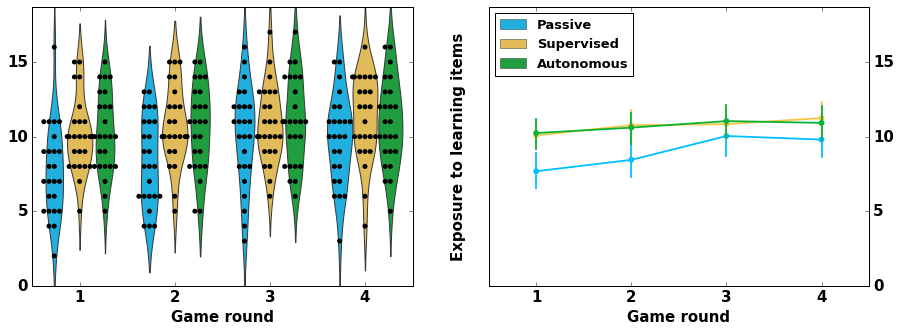

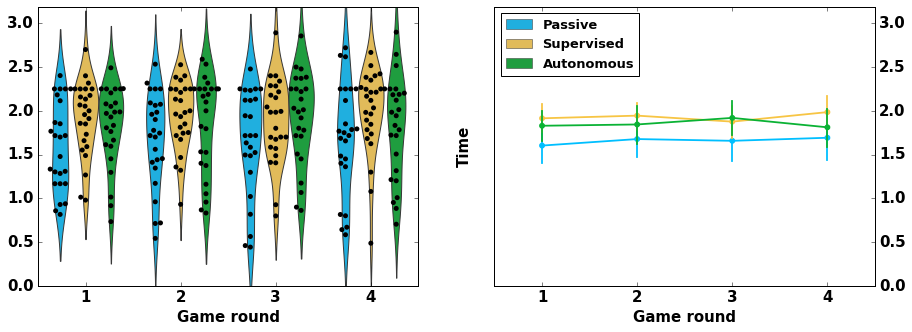

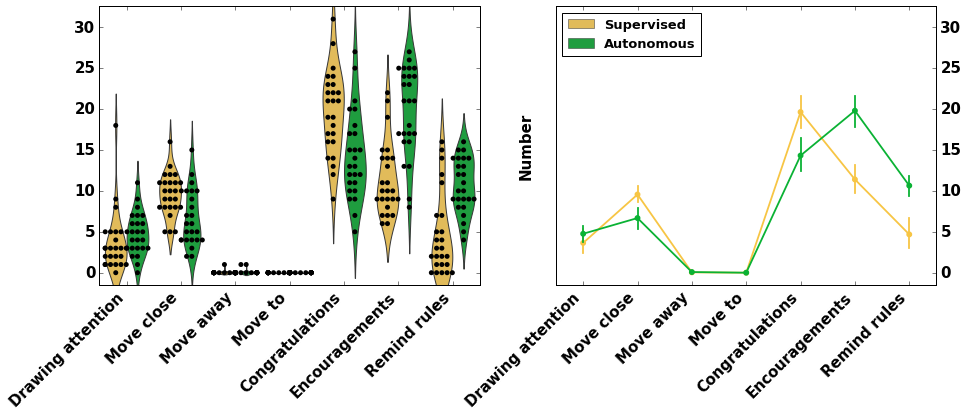

In [39]:
# Graphs
saving=False
sub_frame = df.loc[(df["condition"]=="Supervised") | (df["condition"]=="Autonomous")]
action_categories=["att","mvc","mva", "mvt", "congrats", "encour", "rul"]
action_labels=["Drawing attention","Move close", "Move away", "Move to", "Congratulations", "Encouragements","Remind rules"]

analyse(df,"Game","d_eat","condition","Game round","Exposure to learning items",saving=saving)
analyse(df,"Game","time","condition","Game round","Time", saving=saving)
analyse_actions(sub_frame,action_categories,"condition","","Number",action_labels,saving=saving)

In [40]:
# Tables
sub_frame = df.loc[(df["condition"]=="Supervised") | (df["condition"]=="Autonomous")]
action_categories=["att","mvc","mva", "mvt", "congrats", "encour", "rul"]
action_labels=["Drawing attention","Move close", "Move away", "Move to", "Congratulations", "Encouragements","Remind rules"]

print_table(df,"Game","d_eat","condition","Game round","Exposure to learning items")
print_table(df,"Game","time","condition","Game round","Time")

Exposure to learning items
 & Round 1 & Round 2 & Round 3 & Round 4\\ 
 \midrule 
Passive & 7.7 (3.0) & 8.4 (2.9) & 10.0 (3.3) & 9.8 (3.0)\\ 
Supervised & 10.1 (2.5) & 10.8 (2.6) & 10.8 (2.5) & 11.2 (2.8)\\ 
Autonomous & 10.2 (2.7) & 10.6 (2.9) & 11.0 (2.9) & 10.9 (2.9)\\ 

Time
 & Round 1 & Round 2 & Round 3 & Round 4\\ 
 \midrule 
Passive & 1.6 (0.5) & 1.68 (0.54) & 1.66 (0.6) & 1.69 (0.63)\\ 
Supervised & 1.91 (0.42) & 1.94 (0.39) & 1.88 (0.48) & 1.98 (0.49)\\ 
Autonomous & 1.83 (0.46) & 1.84 (0.55) & 1.92 (0.52) & 1.81 (0.58)\\ 



In [41]:
#Learning gain
cs=["Passive","Supervised","Autonomous"]
for c in cs:
    m=df.loc[df["condition"]==c].learning.mean()
    std=df.loc[df["condition"]==c].learning.std()
    n=1
    if m<2:
        n=2
    s=c+" "+str(round(m,n))
    s+=" ("+str(round(std,n))+")"
    print s

Passive 0.12 (0.14)
Supervised 0.11 (0.13)
Autonomous 0.14 (0.12)


In [42]:
#Demographics
print "Age: "+str(np.mean(df["age"])) +" ("+str(round(np.std(df["age"]),2))+")"
print str(np.sum(df["gender"]=="female"))+"F/"+str(np.sum(df["gender"]=="male"))+"M"

Age: 9.4 (0.71)
37F/38M


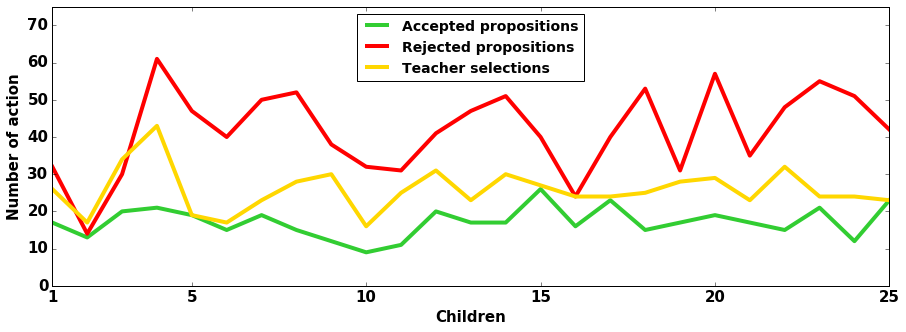

In [43]:
# Supervisor and robot learning

with open("supervisor.json",'r') as f:
    d=json.load(f)
ratio=[]
ratio_accepted=[]
ratio_canceled=[]
good_sug=[]
total_sel=[]
n_proposed=np.zeros(len(d))
n_skip=np.zeros(len(d))
n_press=np.zeros(len(d))
n_autoexe=np.zeros(len(d))
n_enforced=np.zeros(len(d))
n_doit=np.zeros(len(d))
n_select=np.zeros(len(d))
n_reenforced=np.zeros(len(d))
n_cancel=np.zeros(len(d))
n_remove=np.zeros(len(d))

for i, a in enumerate(d):
    n_proposed[i]=len(a["proposed"])
    n_skip[i]=len(a["skip"])
    n_press[i]=len(a["press"])
    n_autoexe[i]=len(a["autoexe"])
    n_enforced[i]=len(a["enforced"])
    n_reenforced[i]=len(a["reenforced"])
    n_doit[i]=len(a["doit"])
    n_select[i]=len(a["select"])
    n_cancel[i]=len(a["cancel"])
    n_remove[i]=len(a["remove"])
    
saving=True
f=plt.figure(figsize=(15,5))
x=np.arange(25)+1
n_good=n_autoexe+n_enforced+n_doit+n_reenforced
n_bad=n_cancel + n_remove + n_skip - n_reenforced
n_teacher = n_select - n_reenforced - n_enforced
n_good_child=np.zeros(len(n_good)/4)
n_bad_child=np.zeros(len(n_bad)/4)
n_teacher_child=np.zeros(len(n_teacher)/4)
for i in range(len(n_good_child)):
    n_good_child[i]=n_good[4*i]+n_good[4*i+1]+n_good[4*i+2]+n_good[4*i+3]
    n_bad_child[i]=n_bad[4*i]+n_bad[4*i+1]+n_bad[4*i+2]+n_bad[4*i+3]
    n_teacher_child[i]=n_teacher[4*i]+n_teacher[4*i+1]+n_teacher[4*i+2]+n_teacher[4*i+3]

plt.plot(x,n_good_child,'limegreen',linewidth=4, label="Accepted propositions")
plt.plot(x,n_bad_child,'r',linewidth=4, label="Rejected propositions")
plt.plot(x,n_teacher_child,'gold',linewidth=4, label="Teacher selections")
plt.ylabel("Number of action",**font)
plt.xlabel("Children",**font)
plt.legend(prop={'size': 14}, loc="upper center")
plt.xticks(list(plt.xticks()[0]) + [1])
plt.xlim(1,25)
plt.ylim(0,75)

if saving:
    f.savefig(path+"summary_supervision.pdf",bbox_inches="tight")
plt.show()

In [44]:
#Mean and standard deviation of actions

print str(round(np.mean(n_good_child),1))+" ("+str(round(np.std(n_good_child),1))+")"
print str(round(np.mean(n_bad_child),1))+" ("+str(round(np.std(n_bad_child),1))+")"
print str(round(np.mean(n_teacher_child),1))+" ("+str(round(np.std(n_teacher_child),1))+")"

g=np.sum(n_good_child)
b=np.sum(n_bad_child)

17.2 (4.0)
41.7 (11.1)
25.8 (5.8)
